# Milestone 1
## DSCI 525 Web and Cloud Computing
## Group 16

This notebook downloads various observed and simulated rainfall data sets from New South Wales, Australia over the period of 1889 - 2014.  The data are then combined and basic exporatory data analyses are conducted using both Python and R programming languages.

In [1]:
import re
import os
import zipfile
import requests
from urllib.request import urlretrieve
import json
import rpy2.rinterface
import dask.dataframe as dd
import pandas as pd
from memory_profiler import memory_usage

In [2]:
#%load_ext rpy2.ipython
%load_ext memory_profiler

# Data Download
The following code chunk downloads the data used in the subsequent analyses.  The data are downloaded from 'figshare.com'.  The file 'data.zip' is saved to a local directory called 'data'.

In [3]:
%%time
%%memit
# Print out time and memory taken for downloading data

# This code is adapted from DSCI 525 lecture demonstration notebook (Gittu George, 2021,
# https://github.ubc.ca/MDS-2020-21/DSCI_525_web-cloud-comp_students/blob/master/Lectures/Lecture_1_2.ipynb)
url = f"https://api.figshare.com/v2/articles/14096681"
headers = {"Content-Type": "application/json"}
output_directory = "data/"

response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]

for file in files:
    if file["name"] in "data.zip":
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

peak memory: 87.70 MiB, increment: 4.52 MiB
CPU times: user 7.36 s, sys: 6.51 s, total: 13.9 s
Wall time: 6min 6s


After it has been downloaded locally, 'data.zip' is extracted and stored in the 'data' directory.

In [4]:
%%time
%%memit
# Print out time and memory taken to extract data

with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), "r") as f:
    f.extractall(output_directory)

peak memory: 73.12 MiB, increment: 1.23 MiB
CPU times: user 17.1 s, sys: 3.1 s, total: 20.2 s
Wall time: 23 s


So annoying to load all csvs into ram, combine, then resave.  Would be much easier if we could stitch the files together directly without loading them into RAM.

# Combining Data
The following code chunk combines all of the unzipped rainfall data .csv files into a single file called 'combined_data.csv'.  This process is accomplished by creating a pandas dataframe called `full_df`, then one by one loading each .csv file and concatenating it with `full_df`.  This requires that all of the .csv files be read into a pandas dataframe variable and held in RAM at once.  In this case, this requires that almost 7 GB of data be held in RAM and manipulated.  Some computers will not be able to perform this data combining operation because they do not have sufficient RAM.  Even for systems which have sufficient RAM, performing simple operations (such as concatenation) on on a variable of this size are time consuming.  To demonstrate this, below the code chunk, we have included screen shots of the time and memory usage for the execution of this data combining operation.  To summarize, the time taken to complete this operation on each system are listed below (along with some general hardware specifications):
1.  Wall time: 7min 9s; Peak memory: 6891.53 MiB
  - Processor: i7-10510U (4 cores, up to 4.90 GHz)
  - RAM: 16 GB

In [5]:
%%time
%%memit
# Print out time and memory taken to merge and save csv files

file_names = os.listdir(output_directory)
file_names = [file for file in file_names if file[-4:] == ".csv"]


cols = ["lat_min", "lat_max", "lon_min", "lon_max", "rain (mm/day)"]
full_df = pd.DataFrame(columns=["model"] + cols)
full_df.index.rename("time", inplace=True)

for file in file_names:
    model_name = re.search("^.*(?=_daily)", file).group(0)
    full_df = pd.concat(
        [
            full_df,
            pd.read_csv(output_directory + file, index_col=0).assign(model = model_name),
        ]
    )

full_df.to_csv(output_directory + "combined_data.csv")

peak memory: 4888.21 MiB, increment: 4815.06 MiB
CPU times: user 6min 58s, sys: 56.2 s, total: 7min 54s
Wall time: 8min 12s


1. Processor: i7-10510U (4 cores, up to 4.90 GHz); RAM: 16 GB

![](../img/i7-10510_16GB-SP.png)

2. Processor: 2.3 GHz Quad-Core Intel Core i5; RAM: 8GB


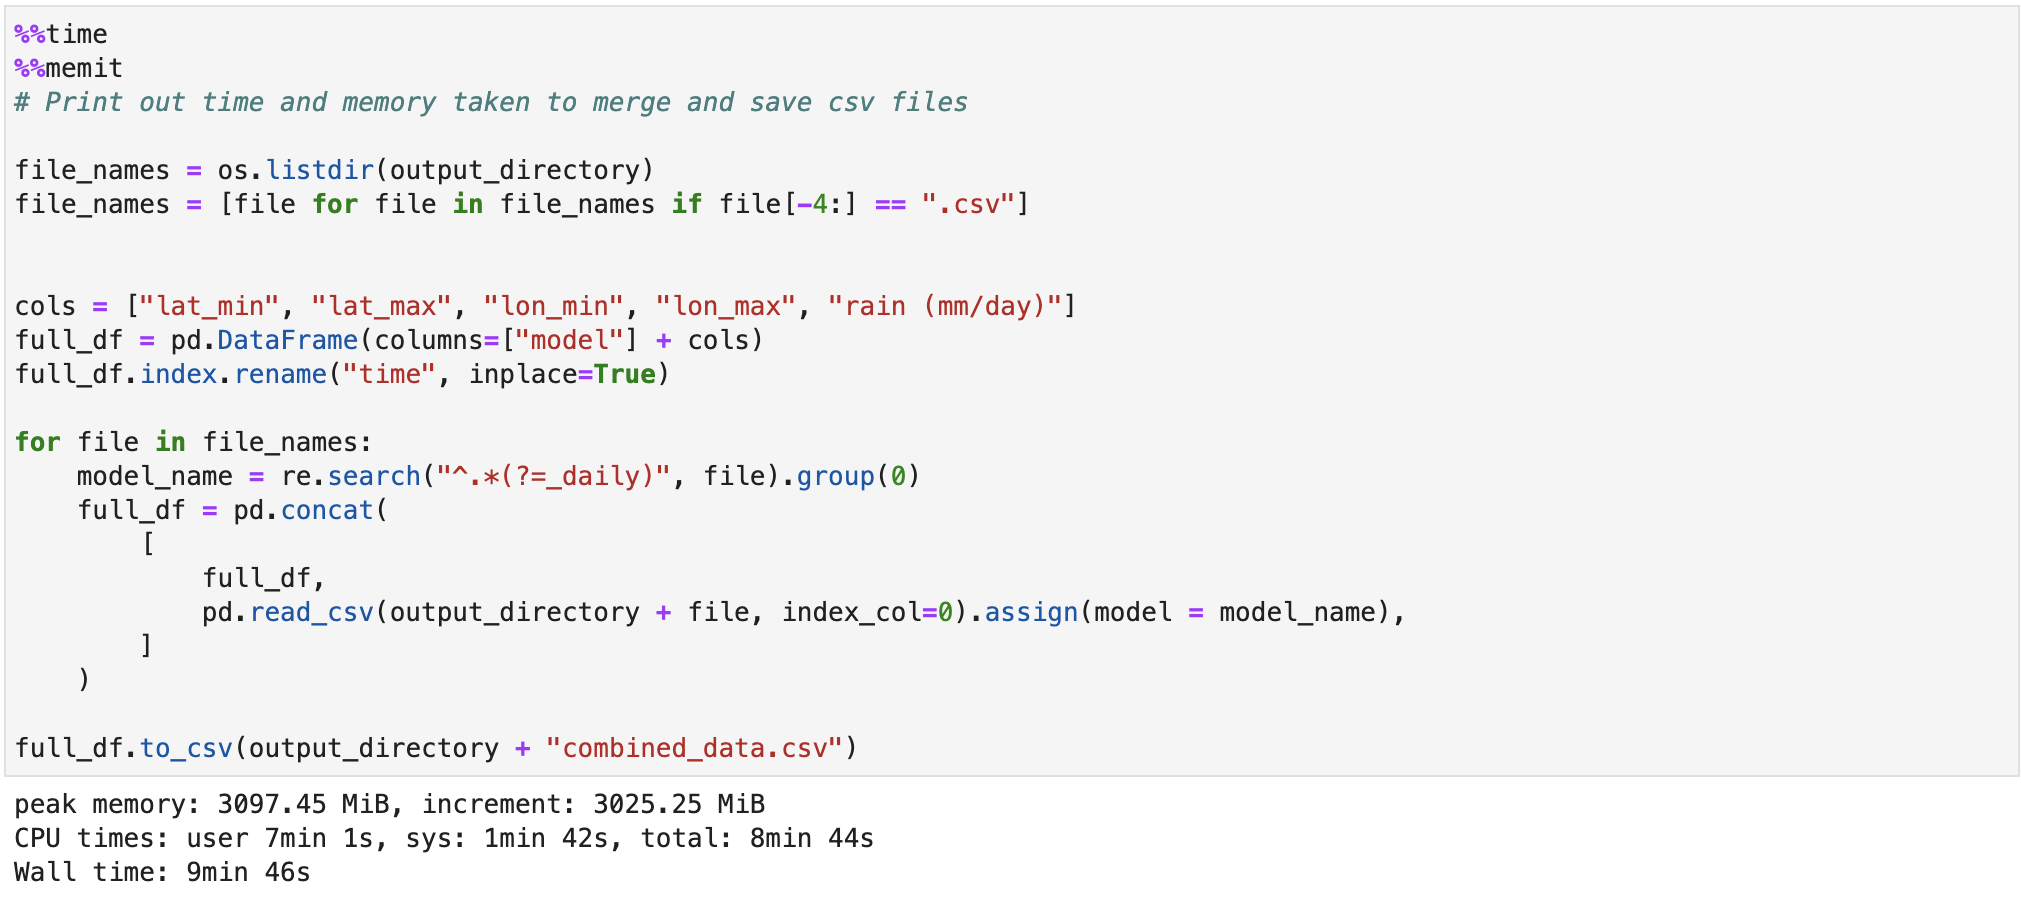

## Task 5. Load the combined CSV to memory and perform a simple EDA

### 1. Investigate at least 2 approaches and perform a simple EDA

In [7]:
full_df.head()

,model,lat_min,lat_max,lon_min,lon_max,rain (mm/day)
time,,,,,,
1889-01-01 12:00:00,MPI-ESM-1-2-HAM,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13
1889-01-02 12:00:00,MPI-ESM-1-2-HAM,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13
1889-01-03 12:00:00,MPI-ESM-1-2-HAM,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13
1889-01-04 12:00:00,MPI-ESM-1-2-HAM,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13
1889-01-05 12:00:00,MPI-ESM-1-2-HAM,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13


In [8]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62513863 entries, 1889-01-01 12:00:00 to 2014-12-31 12:00:00
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   model          object 
 1   lat_min        float64
 2   lat_max        float64
 3   lon_min        float64
 4   lon_max        float64
 5   rain (mm/day)  float64
dtypes: float64(5), object(1)
memory usage: 3.3+ GB


In [11]:
full_df.dtypes

model             object
lat_min          float64
lat_max          float64
lon_min          float64
lon_max          float64
rain (mm/day)    float64
dtype: object

#### Method 1: Loading in Chunks

In [ ]:
%%time
%%memit
import dask.dataframe as dd

### Code adapted from DSCI 525 Lecture ipynb notebook (Gittu George, 2021)
counts = pd.Series(dtype = int)
for chunk in pd.read_csv("../data/combined_data.csv", chunksize = 10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value = 0)
print(counts.astype(int))

#### Method 2: Using Dask

In [ ]:
%%time
%%memit

### Code adapted from DSCI 525 Lecture ipynb notebook (Gittu George, 2021)

dask_df = dd.read_csv("../data/combined_data.csv")
print(dask_df["model"].value_counts().compute())

#### Method 3: Loading just columns what we want

In [ ]:
%%time
%%memit

# The only column we want is the model column
model_df = pd.read_csv("../data/combined_data.csv", usecols = ["model"])
print(model_df["model"].value_counts())

### 2. Observations discussion.